# Design of Word Vector (GloVe) from scratch used for Natural Language Processing tasks

#### In this project, I will show how to train our own word vectors(GloVe) by using the skip-gram model. 

#### The algorithm for training GloVe (Global Vector) was originated from Standford University. This notebook is about studying the Standford GloVe algorithms and transferring the algorithms into codes. For the original paper, please go to: 

https://nlp.stanford.edu/pubs/glove.pdf

#### In this project, we use wikipedia data to train the word vectors. 

#### For NLP tasks, we could surely use pre-trained word vectors provided by others. But instead, in this project, I will show how to train word vectors from scratch by just using python's NumPy library. After mastering this technqiue, we could design our own word vectors and apply it to anywhere we want. 


In [1]:
import numpy as np
import os
import re
from tqdm import tqdm
import json
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

In [2]:
class Wikipedia_Data(): 
    
    """
    This class gets wikipedia data and do pre-processing
    
    """
    
    def __init__(self):
        self.word2indx = None
        self.indx2word = None
        self.sentences_index = None
        
    def get_files(self,path):
        
        files = os.listdir(path)
        joined_paths = []
        for file in files[1:]:
            joined_paths.append(path + file)
        
        return joined_paths
   
    def data_preprocess(self,files):
        all_words={}
        sentences = []
        regex="[-*={|\[]"
        for address in tqdm(files):
            with open(address,'r') as f:
                lines = f.readlines()
            for line in lines:
                line = line.strip()
                # some sentences with the beginning of weird symbols in wikipedia data are typically the titles 
                # or some trivial descriptive notes that we are interested in for training purposes
                if len(line)>0 and len(re.findall(regex,line[0]))==0:
                    line = line.lower()
                    # substitute all non letter characters with whitespace, which only leaves actual words for training
                    # Note: <We could also try include the common punctuation marks into training set.>
                    line = re.sub('[^a-z]',' ',line)
                    words = line.split()
                    sentences.append(words)
                    # Count word frequency
                    for w in words:
                        if w not in all_words:
                            all_words[w] = 0
                        all_words[w]+=1  
        
        return all_words, sentences
        
    def wordindx_mapping(self,path,M):
        files = self.get_files(path)
        print ("data preprocessing...")
        word_freq, sentences = self.data_preprocess(files)
        
        # Choose M most frequent words as V (Note: M is a hyperparameter)
        most_freq = sorted(word_freq.items(),key=lambda x: x[1],reverse=True)[:M]   
        self.word2indx = {w[0]:i for i,w in enumerate(most_freq)}
        # Add an unknown key because when mapping all the sentences later by using the map, if this unknown key does
        # not exist, then when mapping the words that do not exist in the vocabulary, the algorithm will lead to error.
        # Note: However, this unknown key won't actually be trained because there is a great chance that this key 
        # will become a highly (probably the most) frequent key according to its frequency in sentences.
        # Highly frequent keys will be dropped out later in the dropout function because highly frequent keys
        # won't give useful information as either a central word or a context word.
        self.word2indx['<UNK>'] = M
        self.indx2word = {v:k for k,v in self.word2indx.items()}
        self.sentences_index = []
        print ("generating sentences...")
        for sent in tqdm(sentences):
            sent_index = []
            for w in sent:
                if w in self.word2indx:
                    sent_index.append(self.word2indx[w])
                else:
                    sent_index.append(self.word2indx['<UNK>'])

            self.sentences_index.append(sent_index)
        
        

In [3]:
class GloVe_by_ALS():
    
    """
    This class is aimed to train the GloVe.
    
    """
    def __init__(self,V,context_size=10,D=80):
        
        self.context_size = context_size
        self.V = V
        self.D = D
        self.X = np.zeros((V,V))
        # Matrix Factorizaton: X = W*(U.T)
        self.W = None
        self.U = None
        # bias terms
        self.b = None
        self.c = None
        # global mean
        self.mu = 0
        self.unigram = None
          
    def dropout(self,sentences,balance_factor=0.75,threshold=1e-5,eta=1e-8):
        
        """
        Dropout on most frequent words, for example, if the probability of a word appearing in a sentence is more than
        90%, then we dropout this word.

        The aim of dropout is to improve the training. For example, word 'the' is recognized as a drop-out word. If we
        put 'the' into training dataset, no matter what role 'the' plays, either as central word or context word, there
        will be a variety of words surrounding 'the', which means 'the' does not have a preference on its relevant words.
        Therefore, 'the' has little contribution to the training, probably would even act as a disturbation.

        But those drop-out words will eventually be classified together even though they don't go through the training process.
        This is because other words all going through the training process leaves those drop-out words to be classified 
        automatically.
        
        eta is used for smmothing because some values in the unigram will be zero which will become a hinderance when
        computing p_drop (unigram act as the denominator). Therefore, we add an eta smoothing to unigram. Typical value for eta
        would be less than 1e-6 because we don't want to change the value of unigram too much to affect the dropout.
        
        """
        
        print("generating dropout probability...")
        word_freq = np.zeros(self.V)
        total_word_count = np.sum([len(sent) for sent in sentences])
        for sent in sentences:
            for w in sent:
                word_freq[w] +=1
        
        # balance factor makes more frequent words a little bit less frequent, 
        # and less frequent words a little bit more frequent, in order to reduce the gap
        unigram = word_freq**balance_factor/np.sum(word_freq**balance_factor)
        
        # add-eta smoothing 
        unigram+=eta
        
        # threshold is a hyperparameter that decides the drop-out probability, typically around 1e-5
        # for infrequent words, p_drop will be very low, some of which will be negative
        # therefore, technically, p_drop is not a probability, but act the same as a probability
        
        p_drop = 1-np.sqrt(threshold/unigram)    
        
        
        
        return p_drop
        
    def update_matrix(self,pos,sent):
        """
        Update V*V true word matrix.
        """  
        start_index = max(0,pos-self.context_size)
        end_index = min(len(sent)-1,pos+self.context_size)
        context_words = []
        central_word = sent[pos]
        for i in range(start_index,end_index+1):
            # find the context words
            context_w = sent[i]
            if i<pos:
                context_words.append(context_w)
                self.X[central_word,context_w]+= (1/(pos-i))
                self.X[context_w,central_word]+= (1/(pos-i))
            elif i>pos:
                context_words.append(context_w)
                self.X[central_word,context_w]+= (1/(i-pos))
                self.X[context_w,central_word]+= (1/(i-pos))        

        
    def true_word_matrix(self,sentences,drop_out=0.90):
        """
        Create V*V true word matrix used as the label.
        """
        p_drop = self.dropout(sentences)
        print("generating true word matrix...")
        for sent in tqdm(sentences):
            #drop the word when p_drop is bigger than drop-out probability
            sent = [w for w in sent if p_drop[w]<drop_out]
            #check after drop-out, if it is still qualified as a sentence
            if len(sent) < 2:
                continue
            random_pos = np.random.choice(len(sent),size=len(sent),replace=False)

            for pos in random_pos:
                #the middle word
                word = sent[pos]
                self.update_matrix(pos,sent)  

    def train(self,lr=1e-4,lamda=0.1,epochs=30):
        
        """
        This is the (Alternating Least Square) ALS train method. The mathematics behind this algorithm is highly
        relevant to Matrix Factorization technique applied within the field of Recommender Systems.
        For an elaborate explanation on mathematics behind this algorithm, please refer to "Matrix Factorization
        on word vectors in NLP.py"
        
        The regularization term lamda is typically set to 0.1.
        The model's learning rate should be tried multiple times, 1e-4 is a good value to start with.
        
        """
        print("training...")
        # add-1 smoothing
        logX = np.log(self.X+1)
        V = self.V
        D = self.D
        W = np.random.randn(V,D) 
        U = np.random.randn(V,D) 
        b = np.zeros((V,1))
        c = np.zeros((V,1))
        mu = logX.mean()
        self.costs=[]
        fX = self.weight_factor(score=100,alpha=0.75)
        for e in tqdm(range(epochs)):
            # Compute the costs
            element = np.dot(W,U.T)+b+c.T+mu - logX
            cost = (fX*(element*element)).sum()
            self.costs.append(cost)

            for i in range(V):
                
                matrix = np.zeros((D,D))
                vec = np.zeros(D)
                matrix = (fX[i,:]*U.T).dot(U) + lamda*np.eye(D)
                vec = (fX[i,:]*(logX[i,:]-b[i]-c.reshape(-1)-mu)).dot(U)
                W[i] = np.linalg.solve(matrix,vec)

            for j in range(V):
                A_matrix = np.zeros((D,D))
                b_vec = np.zeros(D)
                matrix = (fX[:,j]*W.T).dot(W) + lamda*np.eye(D)
                vec = (fX[:,j]*(logX[:,j] - b.reshape(-1) - c[j] - mu)).dot(W)
                U[j] =  np.linalg.solve(matrix,vec)

            for i in range(V):
                
                b[i] = (1/(fX[i,:].sum()+lamda))*(fX[i,:].dot(logX[i,:]-W[i,:].dot(U.T)-c.reshape(-1)-mu))


            for j in range(V):
                
                c[j] = (1/(fX[:,j].sum()+lamda))*(fX[:,j].dot(logX[:,j] - W.dot(U[j,:]) - b.reshape(-1) - mu))

    
        self.W = W
        self.U = U
        self.b = b
        self.c = c
        self.mu = mu
    
    def weight_factor(self,score,alpha):
        
        """
        If an entry of the word-by-word matrix is less than the value of score, then add a weight factor 
        to the entry. In addition, the entry is also balanced by the alpha because we want the entry with
        much lower values to increase in a more significant way that the entry with much higher value after
        being applied by alpha. In this way, we can reduce the gap created by weight factor between entry 
        with lower value and entry with higher value. According to the research articles, adding a weight factor fX
        as well as a balanced factor alpha could generally improve the performance of the training process.
        
        score is a hyperparameter that acts as a threshold. If the entry in word-by-word matrix is higher than
        the score, then this entry would accordingly be assigned to a weight factor 1; whereas if the entry is
        lower than the score, then this entry would accordingly be assigned to a weight factor(<1) which is the 
        proportion of the entry value to the score.
        
        """
        
        fX = np.zeros((V,V)) 
        fX[self.X<score] = (self.X[self.X<score]/float(score))**alpha
        fX[self.X>=score] = 1.0
        
        return fX

In [4]:
class Test():
    
    """This class is used for testing the trained model."""
    
    
    def __init__(self,weight,distance_metric):
        
        """
        Options of options include: 
        
        (1) the original W matrix;
        
        (2) the average weight of W and U matrices, i.e., (W+U)/2
        
        (3) the concatenated form of W and U matrices.
        
        Options of Metric include:
        
        (1) euclidean distance
        
        (2) cosine distance
        
        From the past experience, the average form of weights performed slightly better than the others
        
        Euclidean or cosine metrics have similar performances.
        
        """
        
        self.W = weight
        self.metric = distance_metric
        
    def k_nearest_neighbors(self,word,k):
        
        """
        This function finds the k nereast neighbors of the given word.
        That is to say, this function returns k most relevant words of the given word.
        """
        
        k_nearest_words = []
        
        if word not in word2indx:
            
            s = "%s is not in the vocabulary." % word
            
            return s
        
        indx = word2indx[word]
        vec = self.W[indx,:].reshape(1,-1)
        for i in pairwise_distances(vec,self.W,metric=self.metric).reshape(V).argsort()[:k]:
             k_nearest_words.append(indx2word[i])
                
        return k_nearest_words
    
    def analogy(self,w1,w2,w4,k):
        
        """
        This function performs an analogy test.
        
        In a set of four words, given three words (w1,w2,w4), the function can return the fourth word which makes
        the following "word equation" valid.
        
        w1 - w2 = w3 - w4
        
        Example:
        
        'france' - 'french' = 'china' - 'chinese'
        
        Given three words 'france'(w1), 'paris'(w2), and 'chinese'(w3), the best result that this function can yield
        
        is to return the word 'china'.
        
        The logic behind this is that france and china are both names of countries whereas french and chinese are both 
        their corresponding adjectives. Therefore, we can say that subtracting 'french' from 'france' is equivalent to
        subtracting 'chinese' from 'china'.
        
        The analogy test is a way to measure the performance of the trained word vectors. If the word vectors are trained
        well, then the it should give the perfect result, namely 'china' in the example above.
        
        Parameter k means the function returns the k nereast words that would satisfy the "word equation" and picks
        the word which is considered as the nereast(best) one for the "word equation".
        
        """
        
        if w1 not in word2indx:
            s =  "%s not in the vocabulary." % w1
            return s
        if w2 not in word2indx:
            s = "%s not in the vocabulary." % w2
            return s
        if w4 not in word2indx:
            s = "%s not in the vocabulary." % w4
            return s
        
        w_lst = [word2indx[w1],word2indx[w2],word2indx[w4]]
        
        vec = (self.W[word2indx[w1],:] - self.W[word2indx[w2],:] + self.W[word2indx[w4],:]).reshape(1,-1)
        
        target = pairwise_distances(vec,self.W,metric=self.metric).reshape(V).argsort()[:k]
        for i in target:
            if i not in w_lst:
                target_i = i
                break
        w3 = indx2word[target_i]

        s = w1 + " - " + w2 + " = " + w3 + " - " + w4

        return s

In [5]:
class Load_Save():
    
    """
    This class saves and loads trained word vectors so that they can be directly put in use whenever needed.
    
    """
    
    def save(self,savedir):
        
        """Save the trained variables."""
        if not os.path.exists(savedir):
            os.mkdir(savedir)

        # save the word2indx dictionary to local PC
        with open('%s/word2indx_ALS.json' % savedir, 'w') as f:
            json.dump(word2indx,f)
        # save the trained word vectors to local PC
        np.savez('%s/W_ALS.npz' % savedir,W,W_avg,W_concat)

    def load(self,loaddir):
        
        """Load the trained variables."""
        try:
            with open('%s/word2indx_ALS.json' % loaddir) as f:
                word2indx = json.load(f)
            npz = np.load('%s/W_ALS.npz' % loaddir)
            W = npz['arr_0']
            W_avg = npz['arr_1']
            W_concat = npz['arr_2']

            return (word2indx,[W, W_avg, W_concat])

        except:

            print("Files are not found.")

            return None

## Train the model

In [6]:
wiki_data = Wikipedia_Data()
wiki_data.wordindx_mapping("./wikipedia data/",M=3000)
word2indx = wiki_data.word2indx
indx2word = wiki_data.indx2word
sentences = wiki_data.sentences_index
V = len(word2indx)
model = GloVe_by_ALS(V)
model.true_word_matrix(sentences=sentences)
model.train()
W = model.W
U = model.U
W_avg = (W+U)/2
W_concat = np.concatenate((W,U),axis=1)
weights = [W,W_avg,W_concat]




  0%|          | 0/8 [00:00<?, ?it/s]

data preprocessing...


  3%|▎         | 4625/156411 [00:00<00:03, 46246.74it/s]

generating sentences...


100%|██████████| 156411/156411 [00:04<00:00, 38339.79it/s]


generating dropout probability...


  0%|          | 164/156411 [00:00<03:10, 821.42it/s]

generating true word matrix...


100%|██████████| 156411/156411 [02:22<00:00, 1100.50it/s]


training...


100%|██████████| 30/30 [04:28<00:00,  9.96s/it]


## Evaluate the cost function

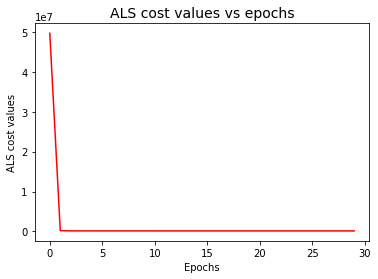

In [10]:
plt.plot(model.costs,'r')
plt.title("ALS cost values vs epochs",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("ALS cost values")
plt.show()

## Test the model

### k-nearest neighbors test

In [11]:

# choose different sorts of weights and metrics
test_W_e = Test(weights[0],'euclidean')
test_W_c = Test(weights[0],'cosine')
test_avg_e = Test(weights[1],'euclidean')
test_avg_c = Test(weights[1],'cosine')
test_concat_e = Test(weights[2],'euclidean')
test_concat_c = Test(weights[2],'cosine')

# find k most relevant words of "software"
print("\nFind 10 most relevant words on \"software\"")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.k_nearest_neighbors('software',10))
print("\n Result of W matrix with cosine distance:\n",test_W_c.k_nearest_neighbors('software',10))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.k_nearest_neighbors('software',10))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.k_nearest_neighbors('software',10),"\n")
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.k_nearest_neighbors('software',10))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.k_nearest_neighbors('software',10))

# find k most relevant words of "medicine"
print("\n\nFind 10 most relevant words on \"medicine\"")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.k_nearest_neighbors('medicine',10))
print("\n Result of W matrix with cosine distance:\n",test_W_c.k_nearest_neighbors('medicine',10))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.k_nearest_neighbors('medicine',10))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.k_nearest_neighbors('medicine',10),"\n")
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.k_nearest_neighbors('medicine',10))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.k_nearest_neighbors('medicine',10))

# find k most relevant words of "female"
print("\n\nFind 10 most relevant words on \"female\"")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.k_nearest_neighbors('female',10))
print("\n Result of W matrix with cosine distance:\n",test_W_c.k_nearest_neighbors('female',10))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.k_nearest_neighbors('female',10))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.k_nearest_neighbors('female',10),"\n")
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.k_nearest_neighbors('female',10))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.k_nearest_neighbors('female',10))

# find k most relevant words of "june"
print("\n\nFind 10 most relevant words on \"june\"")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.k_nearest_neighbors('june',10))
print("\n Result of W matrix with cosine distance:\n",test_W_c.k_nearest_neighbors('june',10))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.k_nearest_neighbors('june',10))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.k_nearest_neighbors('june',10),"\n")
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.k_nearest_neighbors('june',10))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.k_nearest_neighbors('june',10))

# find k most relevant words of "physics"
print("\n\nFind 10 most relevant words on \"physics\"")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.k_nearest_neighbors('physics',10))
print("\n Result of W matrix with cosine distance:\n",test_W_c.k_nearest_neighbors('physics',10))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.k_nearest_neighbors('physics',10))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.k_nearest_neighbors('physics',10),"\n")
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.k_nearest_neighbors('physics',10))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.k_nearest_neighbors('physics',10))

# find k most relevant words of "powerful"
print("\n\nFind 10 most relevant words on \"powerful\"")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.k_nearest_neighbors('powerful',10))
print("\n Result of W matrix with cosine distance:\n",test_W_c.k_nearest_neighbors('powerful',10))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.k_nearest_neighbors('powerful',10))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.k_nearest_neighbors('powerful',10),"\n")
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.k_nearest_neighbors('powerful',10))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.k_nearest_neighbors('powerful',10))

# find k most relevant words of "egyptian"
print("\n\nFind 10 most relevant words on \"egyptian\"")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.k_nearest_neighbors('egyptian',10))
print("\n Result of W matrix with cosine distance:\n",test_W_c.k_nearest_neighbors('egyptian',10))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.k_nearest_neighbors('egyptian',10))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.k_nearest_neighbors('egyptian',10),"\n")
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.k_nearest_neighbors('egyptian',10))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.k_nearest_neighbors('egyptian',10))

# find k most relevant words of "england"
print("\n\nFind 10 most relevant words on \"england\"")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.k_nearest_neighbors('england',10))
print("\n Result of W matrix with cosine distance:\n",test_W_c.k_nearest_neighbors('england',10))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.k_nearest_neighbors('england',10))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.k_nearest_neighbors('england',10),"\n")
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.k_nearest_neighbors('england',10))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.k_nearest_neighbors('england',10))



Find 10 most relevant words on "software"

 Result of W matrix with euclidean distance:
 ['software', 'hardware', 'computer', 'application', 'platform', 'applications', 'programs', 'user', 'ibm', 'program']

 Result of W matrix with cosine distance:
 ['software', 'hardware', 'computer', 'application', 'platform', 'applications', 'apple', 'ibm', 'programming', 'programs']

 Result of average matrix with euclidean distance:
 ['software', 'computer', 'hardware', 'application', 'applications', 'platform', 'systems', 'user', 'operating', 'programs']

 Result of average matrix with cosine distance:
 ['software', 'computer', 'hardware', 'application', 'systems', 'applications', 'platform', 'apple', 'programs', 'user'] 


 Result of concatenated matrix with euclidean distance:
 ['software', 'computer', 'hardware', 'applications', 'application', 'platform', 'systems', 'user', 'apple', 'operating']

 Result of concatenated matrix with cosine distance:
 ['software', 'computer', 'hardware', 'appl

#### From the k-nearest neighbors test, we can observe that occasionally average and concatenated form of word vectors yield k-nearest words which are more reasonable than k-nearest words yielded by the W word vectors. Generally speaking,  average and concatenated form of word vectors performs slightly better than the W word vectors.

### word analogy test

In [21]:
# analogy test

# case 1
print("\n\nFind the word that would satisfy: china - chinese = _ - japanese")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.analogy('china','chinese','japanese',5))
print("\n Result of W matrix with cosine distance:\n",test_W_c.analogy('china','chinese','japanese',5))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.analogy('china','chinese','japanese',5))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.analogy('china','chinese','japanese',5))
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.analogy('china','chinese','japanese',5))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.analogy('china','chinese','japanese',5))

# case 2
print("\n\nFind the word that would satisfy: italy - rome = _ - paris")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.analogy('italy','rome','paris',5))
print("\n Result of W matrix with cosine distance:\n",test_W_c.analogy('italy','rome','paris',5))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.analogy('italy','rome','paris',5))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.analogy('italy','rome','paris',5))
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.analogy('italy','rome','paris',5))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.analogy('italy','rome','paris',5))


# case 3
print("\n\nFind the word that would satisfy: father - son = _ - daughter")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.analogy('father','son','daughter',5))
print("\n Result of W matrix with cosine distance:\n",test_W_c.analogy('father','son','daughter',5))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.analogy('father','son','daughter',5))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.analogy('father','son','daughter',5))
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.analogy('father','son','daughter',5))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.analogy('father','son','daughter',5))

#case 4
print("\n\nFind the word that would satisfy: king - man = _ - woman")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.analogy('king','man','woman',5))
print("\n Result of W matrix with cosine distance:\n",test_W_c.analogy('king','man','woman',5))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.analogy('king','man','woman',5))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.analogy('king','man','woman',5))
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.analogy('king','man','woman',5))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.analogy('king','man','woman',5))

# case 5
print("\n\nFind the word that would satisfy:  actor - male = _ - female")
print("\n Result of W matrix with euclidean distance:\n",test_W_e.analogy('actor','male','female',5))
print("\n Result of W matrix with cosine distance:\n",test_W_c.analogy('actor','male','female',5))
print("\n Result of average matrix with euclidean distance:\n",test_avg_e.analogy('actor','male','female',5))
print("\n Result of average matrix with cosine distance:\n",test_avg_c.analogy('actor','male','female',5))
print("\n Result of concatenated matrix with euclidean distance:\n",test_concat_e.analogy('actor','male','female',5))
print("\n Result of concatenated matrix with cosine distance:\n",test_concat_c.analogy('actor','male','female',5))



Find the word that would satisfy: china - chinese = _ - japanese

 Result of W matrix with euclidean distance:
 china - chinese = japan - japanese

 Result of W matrix with cosine distance:
 china - chinese = japan - japanese

 Result of average matrix with euclidean distance:
 china - chinese = japan - japanese

 Result of average matrix with cosine distance:
 china - chinese = japan - japanese

 Result of concatenated matrix with euclidean distance:
 china - chinese = japan - japanese

 Result of concatenated matrix with cosine distance:
 china - chinese = japan - japanese


Find the word that would satisfy: italy - rome = _ - paris

 Result of W matrix with euclidean distance:
 italy - rome = france - paris

 Result of W matrix with cosine distance:
 italy - rome = france - paris

 Result of average matrix with euclidean distance:
 italy - rome = france - paris

 Result of average matrix with cosine distance:
 italy - rome = france - paris

 Result of concatenated matrix with eucl

#### From the analogy test, we can observe that all three sorts of word vectors performed well except that the concatenated form of word vectors misbehaved a little on the fourth case of the analogy test.


## Save the trained word vectors

In [13]:
load_save = Load_Save()
load_save.save("./trained_wordvec/")

## Use TSNE to visualize the trained word vectors --- Word Cloud

In [14]:
def annotate(X,index_word_map, threshold=0.1):
    
    """
    This is the annotation function for word cloud visualization.
    
    Since there will be words that are very close to each other, we set a threshold. 
    
    If the euclidean distance between the new word vec and the already-placed annotation text of another word vec 
    
    is less than the threshold, then we adjust the annotation text of the new word vec.
    
    Otherwise we might not clearly visualize the word cloud if too many words are too close together.
    
  
    """
    
    N, D = X.shape   
    # this array contains all the wordvecs that are already in the plot
    in_plot = np.zeros((N, D))
    
    for i in tqdm(range(N)):

        # if the new wordvec is too close to the annotation texts of other wordvecs already in the plot,
        # then move the annotation text of this new wordvec a little bit by altering text location (x,y)
        relocated = []

        x, y = X[i]
        
        for _ in range(3):
            for j in range(i):
                diff = np.array([x, y]) - in_plot[j]

                if diff.dot(diff) < threshold:
                    relocated.append(in_plot[j])

            if len(relocated)!=0:
                # relocate the annotation text
                x += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)
                y += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)

            else:    
                break

        in_plot[i] = (x, y)

        annotation = plt.annotate(
          s=index_word_map[i],
          xy=(X[i,0], X[i,1]),
          xytext=(x, y),
          arrowprops={
            'arrowstyle' : '->',
            'color' : 'black',
          }
        )
        
        annotation.set_fontsize(14)

In [15]:
word2indx,weights = load_save.load("./trained_wordvec/")
# use the average matrix to do visualization
W_matrix_avg = weights[1]
# do dimensionality reduction on wordvec
tsne = TSNE()
Y = tsne.fit_transform(W_matrix_avg)
#plot the word cloud and save the figure
plt.figure(figsize=(150.0, 150.0))
plt.scatter(Y[:,0],Y[:,1],s=100,alpha=0.9)
annotate(Y,indx2word, threshold=0.1)
plt.savefig("./word_vec_ALS.png") 

100%|██████████| 3001/3001 [00:24<00:00, 121.74it/s]
